In [ ]:
# !pip install --upgrade --force-reinstall git+https://github.com/albumentations-team/albumentations.git

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Pascal Voc dataset

In [ ]:
!wget -O "data.tar" "http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar" 

--2021-08-04 07:52:11--  http://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar [following]
--2021-08-04 07:52:11--  https://pjreddie.com/media/files/VOCtrainval_11-May-2012.tar
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/octet-stream]
Saving to: ‘data.tar’

data.tar            100%[===================>]   1.86G  20.5MB/s    in 95s     

2021-08-04 07:53:46 (20.2 MB/s) - ‘data.tar’ saved [1999639040/1999639040]



In [ ]:
!tar -xvf "data.tar" -C "." &> /dev/null #[run this cell to extract tar files]
!rm data.tar

In [ ]:
from glob import glob
import PIL
import pandas
import matplotlib.pyplot as plt

def getlist(traintext):
  traintext=traintext.readlines()
  for i,text in enumerate(traintext):
    traintext[i]=text.split('\n')[0]

  x_list = ('/content/VOCdevkit/VOC2012/JPEGImages/'+pandas.Series(traintext)+'.jpg').tolist()
  y_list = ('/content/VOCdevkit/VOC2012/SegmentationClass/'+pandas.Series(traintext)+'.png').tolist()
  return x_list,y_list

traintext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt','r')
trainvaltext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/trainval.txt','r')
valtext=open('/content/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt','r')
train_list,train_y_list=getlist(traintext)
train_val_list,train_val_y_list=getlist(trainvaltext)
val_list,val_y_list=getlist(valtext)
print(len(train_list),len(train_y_list))
print(len(train_val_list),len(train_val_y_list))
print(len(val_list),len(val_y_list))

1464 1464
2913 2913
1449 1449


In [ ]:
import numpy as np

VOC_CLASSES = np.array([
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
])


VOC_COLORMAP = np.array([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
])
VOC_CLASSES=np.expand_dims(VOC_CLASSES,axis=-1)
# print(VOC_CLASSES.shape,VOC_COLORMAP.shape)
selected=np.concatenate([VOC_CLASSES,VOC_COLORMAP],axis=-1)
np.int32(selected[:,1:])

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0],
       [  0,  64, 128]], dtype=int32)

In [ ]:
import tensorflow as tf
def load_one(path,y_path,selected,dimension=(512,512)):
  x=PIL.Image.open(path).convert('RGB')
  x=x.resize(dimension)
  y=PIL.Image.open(y_path).convert('RGB')
  y=y.resize(dimension)
  y=np.array(y)
  selected=np.int32(selected[:,1:])
  mask=np.zeros_like(y,dtype='int64')
  mask=mask[:,:,0]
  for i in range(selected.shape[0]):
    mask=mask+((tf.reduce_sum((y==selected[i])*1,axis=-1).numpy()==3)*(i+1))
  mask=mask+((mask==0)*1)
  mask=mask-1
  return x,mask

(array([ 0,  9, 12]), array(['background', 'chair', 'dog'], dtype='<U12'))

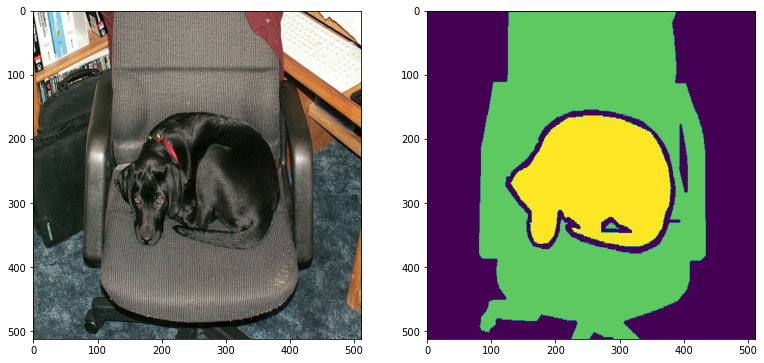

In [ ]:
import numpy as np

img,mask=load_one(train_list[2],train_y_list[2],selected,dimension=(512,512))

fig=plt.figure(figsize=(20,8))
fig.add_subplot(1,3,1)
plt.imshow(img)
fig.add_subplot(1,3,2)
plt.imshow(mask)
np.unique(mask),VOC_CLASSES[np.unique(mask),0]

In [ ]:
# !pip install --upgrade --force-reinstall albumentations &> /dev/null


In [ ]:
from tensorflow.keras.utils import Sequence
import math
import numpy as np
import random
from albumentations import HorizontalFlip, GridDistortion, OpticalDistortion, ChannelShuffle, CenterCrop, Crop, Rotate,Blur
import albumentations as A
import cv2

class Datagenerator(Sequence):
  def __init__(self,x_list,y_list,batch_size=16,augment=False,shuffle=False,dimension=(512,512),log=False):
    self.x_list=x_list
    self.y_list=y_list
    self.batch_size=batch_size
    self.augment=augment
    self.shuffle=shuffle
    self.dimension=dimension
    self.log=log
    self.transform = A.Compose([
        # A.RandomCrop(width=dimension[0], height=dimension[1]),
        A.HorizontalFlip(p=0.5),
        A.Rotate(border_mode=cv2.BORDER_CONSTANT,limit=45, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4,p=0.5),
        A.Blur(p=0.5,blur_limit=5),
        A.GridDistortion(border_mode=cv2.BORDER_CONSTANT,distort_limit=0.2,p=0.5),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, always_apply=False, p=0.5),
    ])

  def __len__(self):
    return math.ceil(len(self.x_list)/self.batch_size)
  def __getitem__(self,idx):
    x_batch_list,y_batch_list=self.x_list[(idx*self.batch_size):((idx+1)*self.batch_size)],self.y_list[(idx*self.batch_size):((idx+1)*self.batch_size)]
    # print(len(x_batch_list),len(y_batch_list))
    # x_batch=np.array()
    for i in range(len(x_batch_list)):
      
      #data augmentation
      if self.augment:
        img,mask=load_one(x_batch_list[i],y_batch_list[i],selected,dimension=(self.dimension[0]+0,self.dimension[1]+0))
        img=np.array(img)
        mask=np.array(mask)
        mask=np.expand_dims(mask,axis=-1)
        # aug =HorizontalFlip(p=0.7)
        # augmented =aug(image=img,mask=mask)
        # img=augmented['image']
        # mask=augmented['mask']
        # aug = Rotate(limit=45, p=0.7)
        # augmented = aug(image=img, mask=mask)
        # img = augmented["image"]
        # mask = augmented["mask"]
        # aug = ChannelShuffle(p=0.5)
        # augmented = aug(image=img, mask=mask)
        # img = augmented["image"]
        # mask = augmented["mask"]
        augmented = self.transform(image=img, mask=mask)
        img = augmented["image"]
        mask = augmented["mask"]
      else:
        img,mask=load_one(x_batch_list[i],y_batch_list[i],selected,dimension=self.dimension)
        img=np.array(img)
        mask=np.array(mask)
        mask=np.expand_dims(mask,axis=-1)
      if i==0:
        x_batch=np.array(img)
        x_batch=np.expand_dims(x_batch,axis=0)
        y_batch=np.array(mask)
        y_batch=np.expand_dims(y_batch,axis=0)
        # y_batch=np.expand_dims(y_batch,axis=-1)
        # print(x_batch.shape)
      else:
        img=np.expand_dims(img,axis=0)
        mask=np.expand_dims(mask,axis=0)
        x_batch=np.concatenate([x_batch,img],axis=0)
        y_batch=np.concatenate([y_batch,mask],axis=0)
    # print("x_batch",x_batch.shape,"y_batch",y_batch.shape)
    x_batch=x_batch/255
    y_batch=tf.keras.utils.to_categorical(y_batch,num_classes=VOC_CLASSES.shape[0])
    return x_batch,y_batch


  def on_epoch_end(self):
    if self.log:
      print("logging")
      logpreds()
      
    if self.shuffle==True:
      seed=int(random.random()*100)
      random.seed(seed)
      random.shuffle(self.x_list)
      random.seed(seed)
      random.shuffle(self.y_list)

In [ ]:
traingen=Datagenerator(train_list,train_y_list,augment=True,shuffle=True)
# valgen=Datagenerator(val_list,val_y_list,augment=False,shuffle=False)
# testgen=Datagenerator(test_list,test_y_list,augment=False,shuffle=False)

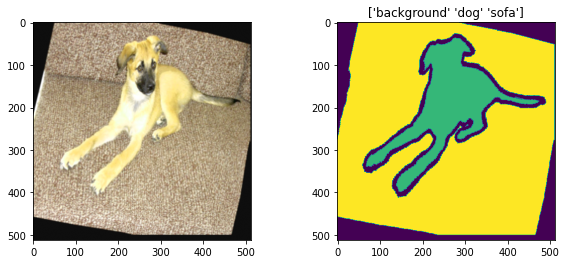

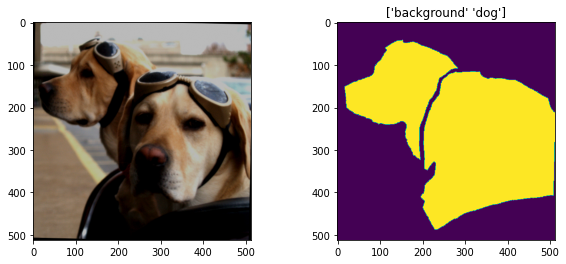

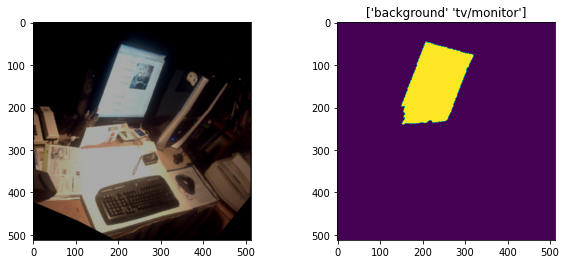

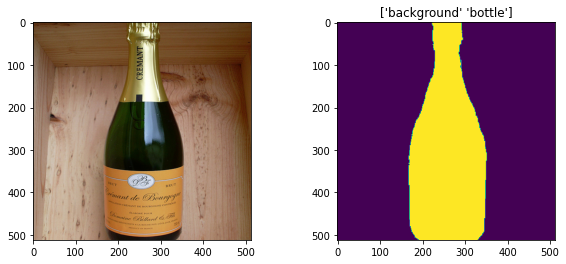

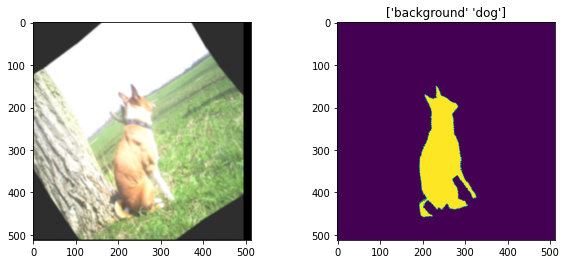

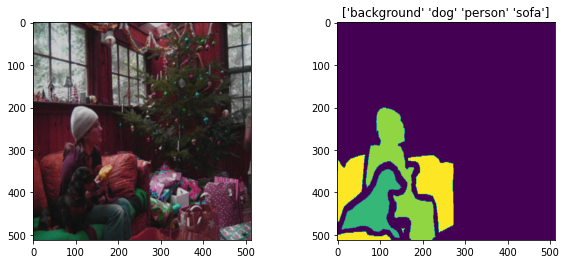

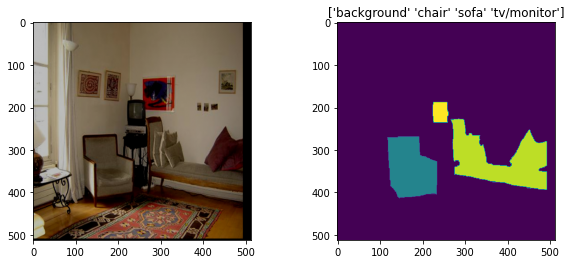

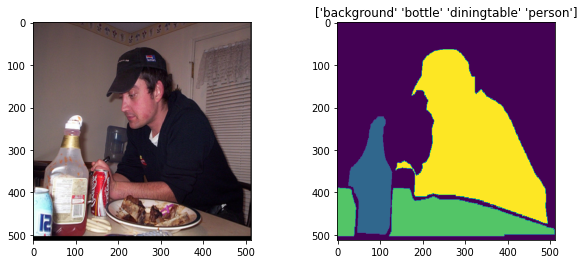

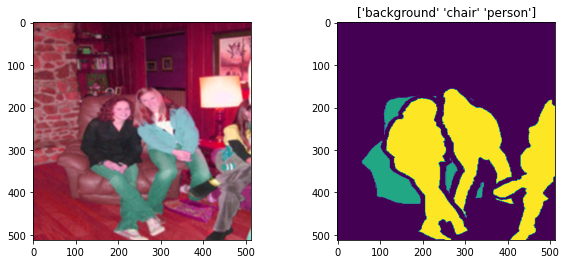

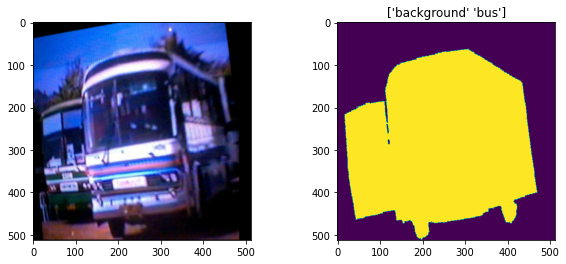

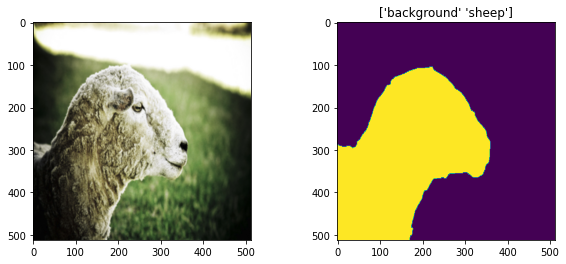

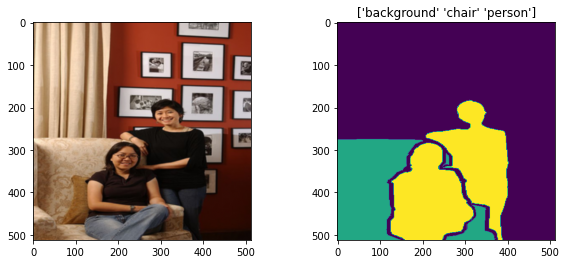

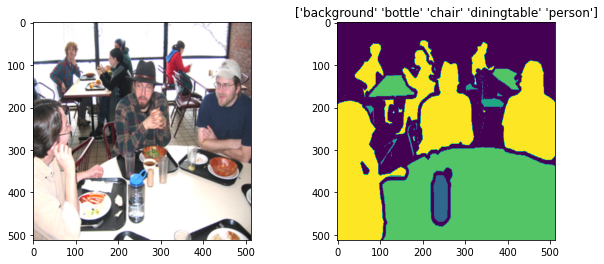

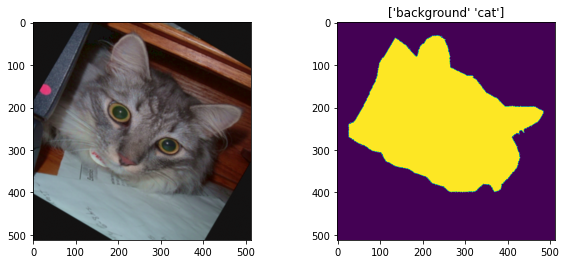

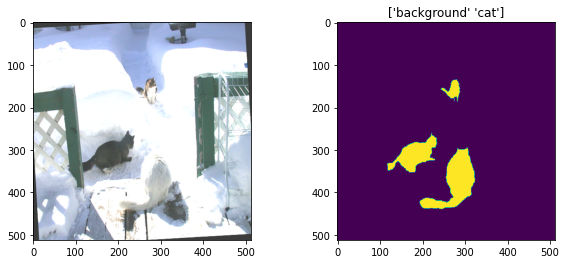

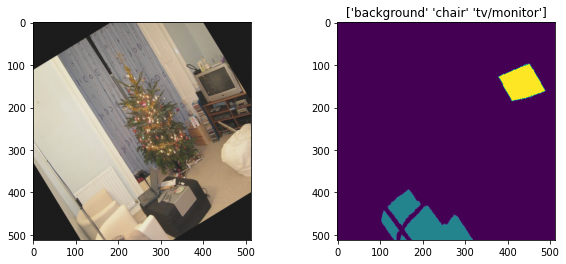

In [ ]:
import matplotlib.pyplot as plt
x,y=traingen.__getitem__(0)
y=np.argmax(y,axis=-1)
for i in range(x.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,2,1)
  plt.imshow(x[i,...])
  fig.add_subplot(1,2,2)
  plt.title(str(VOC_CLASSES[np.unique(y[i,:,:]),0]))
  plt.imshow(y[i,:,:])
traingen.on_epoch_end()

#Deeplab v3+ Model

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D, UpSampling2D, Reshape, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers,Model
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

def squeeze_and_excite(input,rate=8):
  #channel attention shape
  c_a_shape=(1,1,input.shape[-1])
  x=GlobalAveragePooling2D()(input)
  x=Reshape(c_a_shape)(x)
  x=Dense(input.shape[-1]//rate,activation="relu",kernel_initializer="he_normal",use_bias=False)(x)
  x=Dense(input.shape[-1],activation="sigmoid",kernel_initializer="he_normal",use_bias=False)(x)
  # x=tf.expand_dims(x,axis=-2)
  # x=tf.expand_dims(x,axis=-2)
  # print(input.shape)
  # print(x.shape)
  out=input*x
  return out



def ASPP(input):
  x=AveragePooling2D((input.shape[1],input.shape[2]))(input)
  # print(x.shape)
  y1=Conv2D(256,1,padding='same',use_bias=False)(x)
  y1=layers.BatchNormalization()(y1)
  y1=Activation("relu")(y1)
  y1 = UpSampling2D((input.shape[1],input.shape[2]), interpolation="bilinear")(y1)

  y2=Conv2D(256,1,padding="same",use_bias=False)(input)
  y2=layers.BatchNormalization()(y2)
  y2=Activation("relu")(y2)

  y3=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=6)(input)
  y3=layers.BatchNormalization()(y3)
  y3=Activation("relu")(y3)

  y4=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=12)(input)
  y4=layers.BatchNormalization()(y4)
  y4=Activation("relu")(y4)

  y5=Conv2D(256,3,padding="same",use_bias=False,dilation_rate=18)(input)
  y5=layers.BatchNormalization()(y5)
  y5=Activation("relu")(y5)

  y=Concatenate()([y1,y2,y3,y4,y5])
  
  y=Conv2D(256,1,padding="same",use_bias=False)(y)
  y=layers.BatchNormalization()(y)
  y=Activation("relu")(y)
  return y

def deeplab(input_shape,out_channels=1):
  x_input=Input(shape=input_shape)
  #encoder
  x=ResNet50(include_top=False,weights="imagenet",input_tensor=x_input)
  image_features=x.get_layer("conv4_block6_out").output
  # print(image_features.shape)
  x_a=ASPP(image_features)
  x_a=UpSampling2D((4,4),interpolation="bilinear")(x_a)
  # print(x_a.shape)

  x_b=x.get_layer("conv2_block2_out").output
  x_b=Conv2D(48,1,padding="same",use_bias=False)(x_b)
  x_b=layers.BatchNormalization()(x_b)
  x_b=Activation("relu")(x_b)

  x=Concatenate()([x_a,x_b])
  x=squeeze_and_excite(x)

  #decoder
  x=Conv2D(256,3,padding="same",use_bias=False)(x)
  x=layers.BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(256,3,padding="same",use_bias=False)(x)
  x=layers.BatchNormalization()(x)
  x=Activation("relu")(x)
  x=squeeze_and_excite(x)

  x=UpSampling2D((4,4),interpolation="bilinear")(x)
  x=Conv2D(out_channels,1,activation="softmax")(x)
  # print(x.shape)

  model=Model(x_input,x)
  # model.summary()
  return model
# deeplab().summary()

#loss and dice metric

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
def advanced_dice_score(y_true,y_pred,backend=False):

  y_true=tf.cast(y_true,dtype="float32")
  # tf.print(y_true.shape[1]*y_true.shape[2],y_true.shape[3])
  # y_true=K.reshape(y_true,(4,512*512,21))
  y_pred=tf.cast(y_pred,dtype="float32")
  # y_pred=K.reshape(y_pred,(4,512*512,21))
  
  true_channels=(tf.reduce_sum(tf.reduce_sum(y_true,axis=-2),axis=-2)!=0)
  # intersection=tf.reduce_sum(tf.multiply(y_true,y_pred),axis=-2)
  intersection=tf.reduce_sum(tf.reduce_sum(tf.multiply(y_true,y_pred),axis=-2),axis=-2)
  # union=tf.reduce_sum(y_true+y_pred,axis=-2)
  union=tf.reduce_sum(tf.reduce_sum(y_true+y_pred,axis=-2),axis=-2)
  # print('U',union.shape,"I",intersection.shape)
  true_dice=(2*intersection[true_channels]+1e-9)/(union[true_channels]+1e-9)
  # print(true_dice)
  true_dice=tf.reduce_mean(true_dice,axis=0)
  # print(true_dice)

  if backend:
    false_channels=tf.math.logical_not(true_channels)
    intersection=intersection[false_channels]
    # print(intersection)
    union=union[false_channels]
    # print(union)
    # print('U',union.shape,"I",intersection.shape)
    error_dice=(2*intersection+1e-9)/(union+1e-9)
    error_dice=tf.reduce_mean(error_dice,axis=0)
    return true_dice,error_dice
  else:
    return true_dice

In [ ]:
advanced_dice_score(tf.zeros([4,512,512,3],dtype="float32"),tf.zeros([4,512,512,3],dtype="float32"),backend=True)

(<tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

In [ ]:
advanced_dice_score(tf.keras.utils.to_categorical(y[1:2,...],num_classes=VOC_CLASSES.shape[0]),tf.keras.utils.to_categorical(y[6:7,...],num_classes=VOC_CLASSES.shape[0]),backend=True)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.08673832>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9444444>)

In [ ]:
# plt.figure()
# plt.imshow(np.argmax(tf.keras.utils.to_categorical(y[6,...],num_classes=VOC_CLASSES.shape[0]),axis=-1))
# plt.figure()
# plt.imshow(np.argmax(tf.keras.utils.to_categorical(y[1,...],num_classes=VOC_CLASSES.shape[0]),axis=-1))

In [ ]:
from tensorflow import keras
class loss():
  def __init__(self,use_cce=True,use_dice=True):
    self.use_cce=use_cce
    self.use_dice=use_dice

  def dice_cce_loss(self,y_true,y_pred):
    use_cce=self.use_cce
    use_dice=self.use_dice
    loss=0
    if use_cce:
      cce_loss=tf.reduce_mean(keras.losses.categorical_crossentropy(y_true,y_pred))
      loss+=cce_loss
    if use_dice:
      true_dice,false_dice=advanced_dice_score(y_true,y_pred,backend=True)
      t_dice_loss=1-true_dice
      f_dice_loss=(1-false_dice)
      # loss+=t_dice_loss
      loss+=t_dice_loss+f_dice_loss
    return loss

In [ ]:
# print(tf.keras.utils.to_categorical(y,num_classes=VOC_CLASSES.shape[0]).shape)
loss(use_cce=True,use_dice=True).dice_cce_loss( tf.keras.utils.to_categorical(y[1:5,...],num_classes=VOC_CLASSES.shape[0]) , tf.keras.utils.to_categorical(y[5:9,...],num_classes=VOC_CLASSES.shape[0]))
# obj.dice_cce_loss(tf.zeros([4,512,512,3],dtype="float32"),tf.zeros([4,512,512,3],dtype="float32"))

<tf.Tensor: shape=(), dtype=float32, numpy=9.358105>

#Logging predictings

In [ ]:
class_labels ={(i):name[0] for i,name in enumerate(VOC_CLASSES)}
labels_class={(name[0]):i for i,name in enumerate(VOC_CLASSES)}
class_labels

{0: 'background',
 1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'potted plant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tv/monitor'}

In [ ]:
def logpreds():
  img,mask=valgen.__getitem__(0)
  pred=model.predict(img)
  pred=np.uint8((pred>0.5)*1)
  mask=np.argmax(mask,axis=-1)
  pred=np.argmax(pred,axis=-1)
  for i in range(img.shape[0]):

    caption_str=str(','.join(VOC_CLASSES[np.unique(pred[i,...]),0]))

    mask_img = wandb.Image(img[i,...], masks={
      "predictions": {
        "mask_data": pred[i,:,:],
        "class_labels": class_labels
      },
      "ground_truth": {
        "mask_data": mask[i,:,:],
        "class_labels": class_labels
      }

    },caption=caption_str)
    wandb.log({f"predictions{i+1}": mask_img,})

In [ ]:
# wandb.init(project='car segmentation', entity='anujpanthri')
# logpreds()

#Training

In [ ]:
!pip install wandb &> /dev/null
import wandb
from wandb.keras import WandbCallback

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15124571242175641720, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 274769151176522848
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [ ]:
# model=deeplab((512,512,3),21)
# # model.compile(loss=dice_cce_loss,optimizer=keras.optimizers.Adam(0.0001),metrics=[advanced_dice_score])
# model.compile(loss=loss(use_cce=False,use_dice=True).dice_cce_loss,optimizer=keras.optimizers.Adam(0.0001),metrics=[advanced_dice_score])

In [ ]:
1e-4
print(2e-5)

2e-05


In [ ]:
from tensorflow import keras
model=keras.models.load_model("/content/drive/MyDrive/human_segmention/deeplab_dice.h5",compile=False)
model.compile(loss=loss(use_cce=True,use_dice=True).dice_cce_loss,optimizer=keras.optimizers.Adam(2e-5),metrics=[advanced_dice_score])

In [ ]:
traingen=Datagenerator(train_list,train_y_list,augment=True,shuffle=True,batch_size=4,log=True,dimension=(512,512))
trainvalgen=Datagenerator(train_val_list[:-1],train_val_y_list[:-1],augment=True,shuffle=True,batch_size=4,log=True,dimension=(512,512))
valgen=Datagenerator(val_list,val_y_list,augment=False,shuffle=False,batch_size=4,dimension=(512,512))

In [ ]:
wandb.init(project='car segmentation', entity='anujpanthri')

config = wandb.config
callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=10),
           keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience=4,verbose=1,factor=0.1),
           keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/human_segmention/deeplab_dice.h5",monitor='val_loss',save_best_only=True,verbose=1),
           WandbCallback()
           ]

model.fit(traingen,validation_data=valgen,initial_epoch=0,epochs=40,callbacks=callbacks)

Epoch 1/40
366/366 [==============================] - 1179s 3s/step - loss: 1.4434 - advanced_dice_score: 0.7793 - val_loss: 1.7031 - val_advanced_dice_score: 0.7115

Epoch 00001: val_loss improved from inf to 1.70314, saving model to /content/drive/MyDrive/human_segmention/deeplab_dice.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


logging
Epoch 2/40
366/366 [==============================] - 1153s 3s/step - loss: 1.4326 - advanced_dice_score: 0.7882 - val_loss: 1.7209 - val_advanced_dice_score: 0.7102

Epoch 00002: val_loss did not improve from 1.70314
logging
Epoch 3/40
366/366 [==============================] - 1151s 3s/step - loss: 1.4098 - advanced_dice_score: 0.7961 - val_loss: 1.7076 - val_advanced_dice_score: 0.7131

Epoch 00003: val_loss did not improve from 1.70314
logging
Epoch 4/40
366/366 [==============================] - 1141s 3s/step - loss: 1.4126 - advanced_dice_score: 0.7964 - val_loss: 1.7432 - val_advanced_dice_score: 0.7074

Epoch 00004: val_loss did not improve from 1.70314
logging


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f8de0a3b200>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 5/40
  4/366 [..............................] - ETA: 12:04 - loss: 1.4404 - advanced_dice_score: 0.8004

KeyboardInterrupt: ignored

In [ ]:
# model.save("/content/drive/MyDrive/human_segmention/deeplab_dice_0.7112.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
# model.evaluate(valgen)## my model

#Results

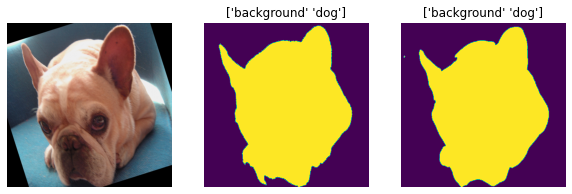

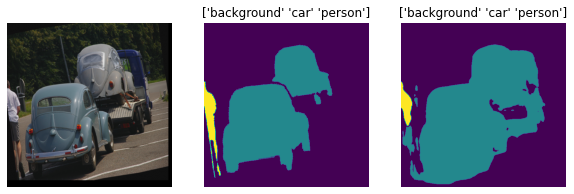

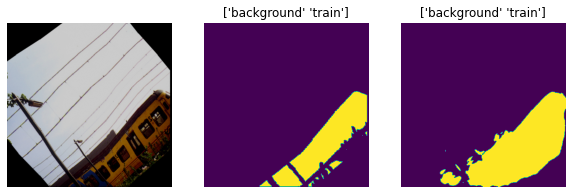

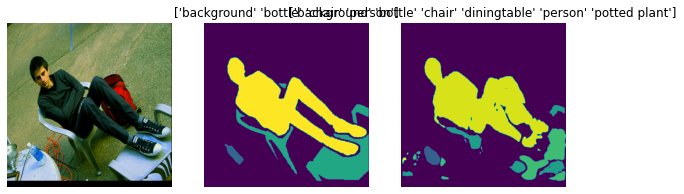

In [ ]:
img,mask=traingen.__getitem__(0)
mask=np.argmax(mask,axis=-1)
for i in range(img.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,3,1)
  plt.axis("off")
  plt.imshow(img[i,...])
  pred=model.predict(img[i:i+1,...])
  pred=(pred>0.5)*1
  pred=np.argmax(pred,axis=-1)
  fig.add_subplot(1,3,2)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(mask[i,:,:]),0]))
  plt.imshow(mask[i,:,:])
  fig.add_subplot(1,3,3)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(pred[0,:,:]),0]))
  plt.imshow(pred[0,:,:])
  # fig.add_subplot(1,3,3)
  # plt.axis("off")
  # plt.imshow(img[i,...]*pred[0,:,:,:])

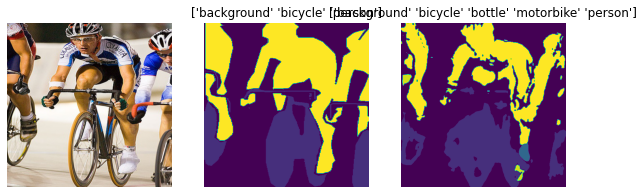

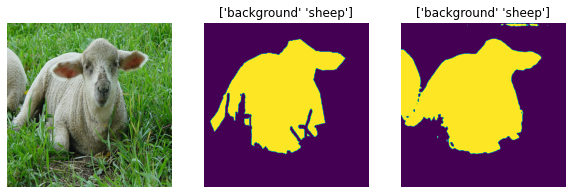

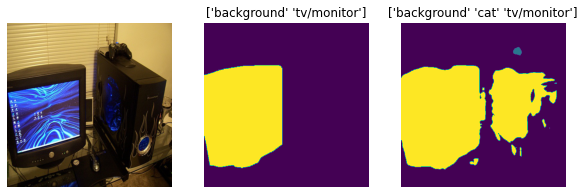

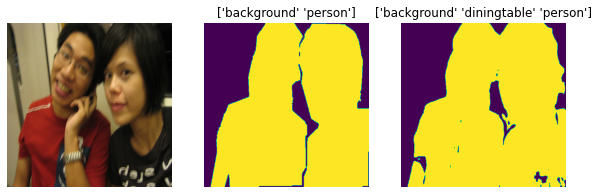

In [ ]:
img,mask=valgen.__getitem__(1)
pred=model.predict(img)
pred=(pred>0.5)*1
pred=np.argmax(pred,axis=-1)
mask=np.argmax(mask,axis=-1)
for i in range(img.shape[0]):
  fig=plt.figure(figsize=(10,4))
  fig.add_subplot(1,3,1)
  plt.axis("off")
  plt.imshow(img[i,...])
  fig.add_subplot(1,3,2)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(mask[i,:,:]),0]))
  plt.imshow(mask[i,:,:])
  fig.add_subplot(1,3,3)
  plt.axis("off")
  plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]),0]))
  plt.imshow(pred[i,:,:])
  # fig.add_subplot(1,3,3)
  # plt.axis("off")
  # plt.imshow(img[i,...]*pred[0,:,:,:])

In [ ]:
import PIL
import matplotlib.pyplot as plt
import numpy as np

def show(imglist):
  batch=[]
  for path in imglist:
    img=PIL.Image.open(path)
    img=img.resize((512,512))
    img=img.convert("RGB")
    img=np.array(img)
    img=np.expand_dims(img,axis=0)
    img=img/255
    batch.append(img)
  batch=np.array(batch)
  batch=np.squeeze(batch,axis=1)
  print(batch.shape)
  pred=model.predict(batch)
  pred=(pred>0.5)*1
  pred=np.argmax(pred,axis=-1)
  ###############################keep
  # keep=(pred==labels_class['person'])*1
  keep=(pred==labels_class['car'])*1
  # pred=pred*keep
  ###############################keep end
  for i in range(pred.shape[0]):
    fig=plt.figure(figsize=(15,10))
    fig.add_subplot(1,4,1)
    plt.axis("off")
    plt.imshow(batch[i,...])

    fig.add_subplot(1,4,2)
    plt.axis("off")
    plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]),0]))
    plt.imshow(pred[i,:,:])

   
    fig.add_subplot(1,4,3)
    plt.axis("off")
    plt.title(str(VOC_CLASSES[np.unique(pred[i,:,:]*keep[i,...]),0]))
    plt.imshow(pred[i,:,:]*keep[i,...])

    # pred=(pred>0.5)*1
    fig.add_subplot(1,4,4)
    plt.axis("off")
    # plt.imshow(img[0,...])
    plt.imshow(batch[i,...]*np.expand_dims((pred[i,:,:]*keep[i,...]>0.5)*1,axis=-1))

(1, 512, 512, 3)


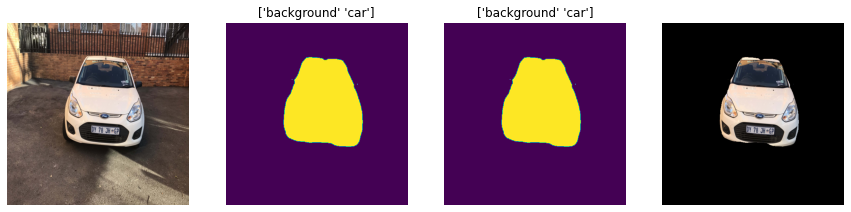

In [ ]:
show(['view1.jpeg'])

(4, 512, 512, 3)


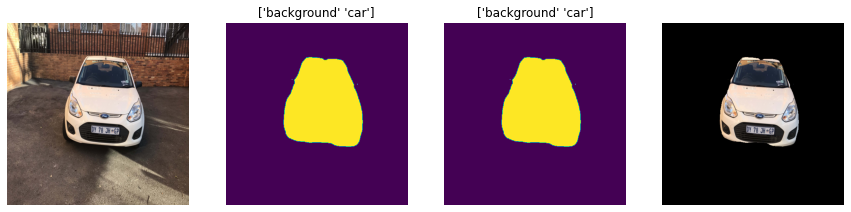

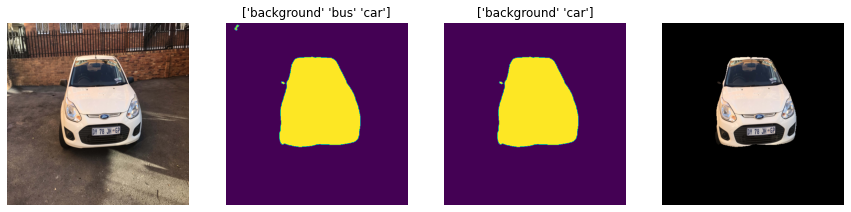

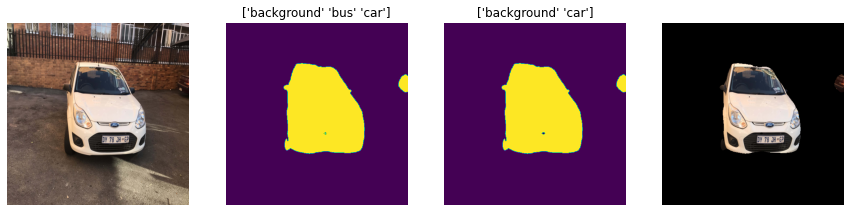

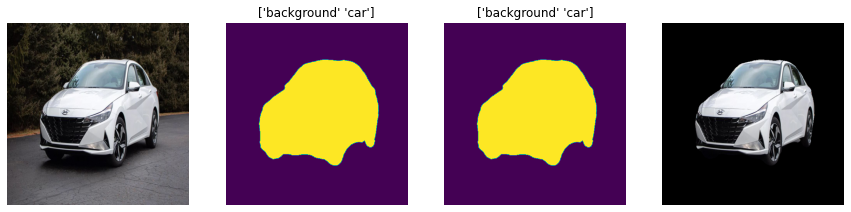

In [ ]:
show(['view1.jpeg','view2.jpeg','view3.jpeg','car.jpg'])

In [ ]:
# !rm -r test

In [ ]:
!mkdir test

(5, 512, 512, 3)


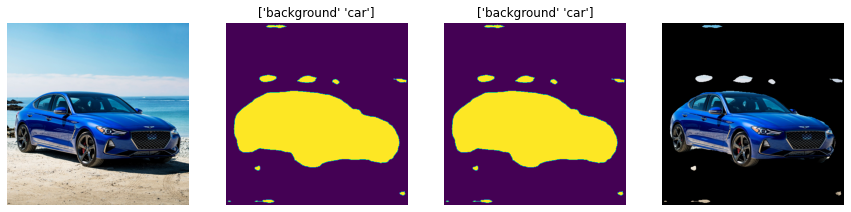

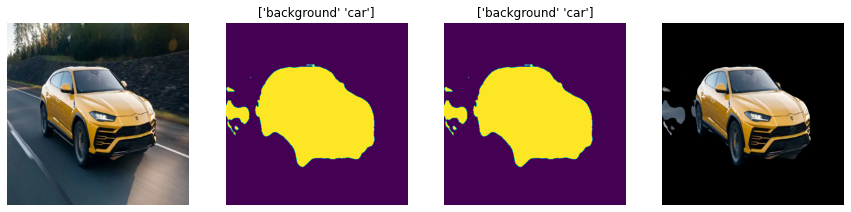

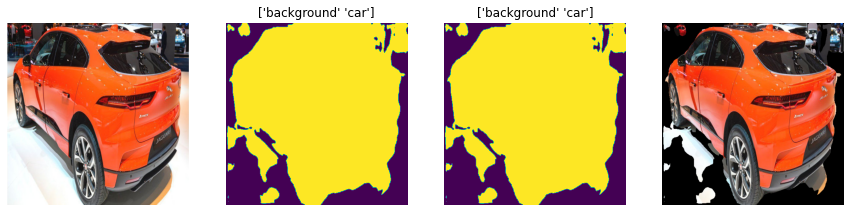

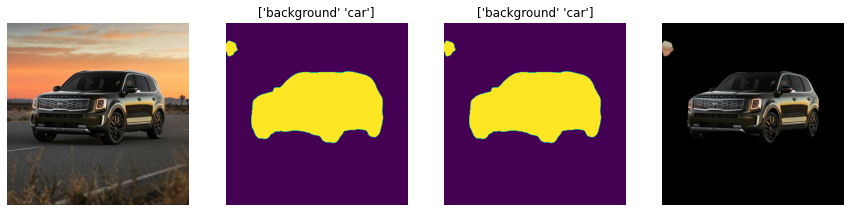

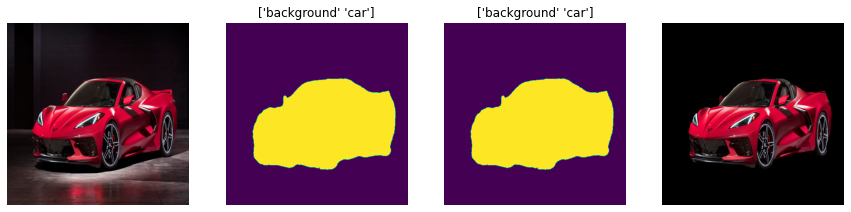

In [ ]:
from glob import glob
show(glob('test/*'))

In [ ]:
img,mask=trainvalgen.__getitem__(1)
# pred=model.predict(img)
# pred

In [ ]:
from keras import backend as K
import numpy as np
inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functors = [K.function([inp], [out]) for out in outputs]    # evaluation functions

# Testing
test = img
layer_outs = [func([test]) for func in functors]
print(len(layer_outs))

187


In [ ]:
import pandas as pd

layers_outputs=[ [tf.reduce_mean(out).numpy(),np.min(out),np.max(out)] for out in layer_outs]

names=[out.name for out in outputs]

df=pd.DataFrame(np.concatenate([np.expand_dims(names,axis=-1),layers_outputs],axis=-1), columns=['layer','avg_out','min','max'])
df

In [ ]:
df.to_csv("log.csv",index=False)

In [ ]:
model.summary()

In [ ]:
model.get_layer("batch_normalization_27").get_weights()